In [1]:
!kaggle datasets download -d medharawat/google-stock-price

Dataset URL: https://www.kaggle.com/datasets/medharawat/google-stock-price
License(s): CC0-1.0
google-stock-price.zip: Skipping, found more recently modified local copy (use --force to force download)


In [2]:
import shutil
shutil.unpack_archive("google-stock-price.zip", "./")

In [3]:
import numpy as np
import pandas as pd

# 데이터 로드
data = pd.read_csv("Google_Stock_Price_Train.csv")
data

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"
...,...,...,...,...,...,...
1253,12/23/2016,790.90,792.74,787.28,789.91,"623,400"
1254,12/27/2016,790.68,797.86,787.66,791.55,"789,100"
1255,12/28/2016,793.70,794.23,783.20,785.05,"1,153,800"
1256,12/29/2016,783.33,785.93,778.92,782.79,"744,300"


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1258 non-null   object 
 1   Open    1258 non-null   float64
 2   High    1258 non-null   float64
 3   Low     1258 non-null   float64
 4   Close   1258 non-null   object 
 5   Volume  1258 non-null   object 
dtypes: float64(3), object(3)
memory usage: 59.1+ KB


In [5]:
data['Close'] = data['Close'].str.replace(",", "").astype(float)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1258 non-null   object 
 1   Open    1258 non-null   float64
 2   High    1258 non-null   float64
 3   Low     1258 non-null   float64
 4   Close   1258 non-null   float64
 5   Volume  1258 non-null   object 
dtypes: float64(4), object(2)
memory usage: 59.1+ KB


In [7]:
data = data[['Date', 'Close']]

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1258 non-null   object 
 1   Close   1258 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.8+ KB


In [9]:
data['Date'] = pd.to_datetime(data['Date'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1258 non-null   datetime64[ns]
 1   Close   1258 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.8 KB


C:\Users\Admin\AppData\Local\Temp\ipykernel_30028\511077666.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = pd.to_datetime(data['Date'])


In [10]:
data.set_index('Date', inplace=True)

In [11]:
data = data['Close'].values

In [12]:
data

array([663.59, 666.45, 657.21, ..., 785.05, 782.79, 771.82])

In [13]:
# 데이터 정규화
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
train_data = scaler.fit_transform(data.reshape(-1, 1))

In [14]:
# 데이터 전처리
X, y = [], []
time_steps = 60

for i in range(len(train_data) - time_steps):
    X.append(train_data[i:i + time_steps])
    y.append(train_data[i + time_steps])
X = np.array(X)
y = np.array(y)

In [15]:
X = X.reshape((X.shape[0], X.shape[1], 1))

In [16]:
split =   int(0.8 * len(X))
x_train, x_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]
x_train.shape

(958, 60, 1)

In [17]:
import torch
import torch.nn as nn

x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)

x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [18]:
class RNN(nn.Module):
    def __init__(self, input_size = 1, hidden_size = 50, num_layers = 1, output_size = 1):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.shape[0], self.hidden_size)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

In [19]:
model = RNN()

In [20]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [21]:
epochs = 20
for epoch in range(epochs):
    model.train()
    outputs = model(x_train)
    optimizer.zero_grad()
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    print(f"{epoch} , Loss : {loss.item():.4f}")

0 , Loss : 0.1080
1 , Loss : 0.0955
2 , Loss : 0.0854
3 , Loss : 0.0775
4 , Loss : 0.0715
5 , Loss : 0.0675
6 , Loss : 0.0649
7 , Loss : 0.0635
8 , Loss : 0.0625
9 , Loss : 0.0616
10 , Loss : 0.0602
11 , Loss : 0.0582
12 , Loss : 0.0557
13 , Loss : 0.0528
14 , Loss : 0.0497
15 , Loss : 0.0466
16 , Loss : 0.0436
17 , Loss : 0.0409
18 , Loss : 0.0383
19 , Loss : 0.0356


In [23]:
import matplotlib.pyplot as plt

# 모델을 평가 모드로 설정
model.eval()

# 학습 데이터와 테스트 데이터에 대한 예측
train_predictions = model(x_train).detach().numpy()
test_predictions = model(x_test).detach().numpy()

# 예측값과 실제값의 스케일을 원래대로 되돌림
train_predictions = scaler.inverse_transform(train_predictions)
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
test_predictions = scaler.inverse_transform(test_predictions)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

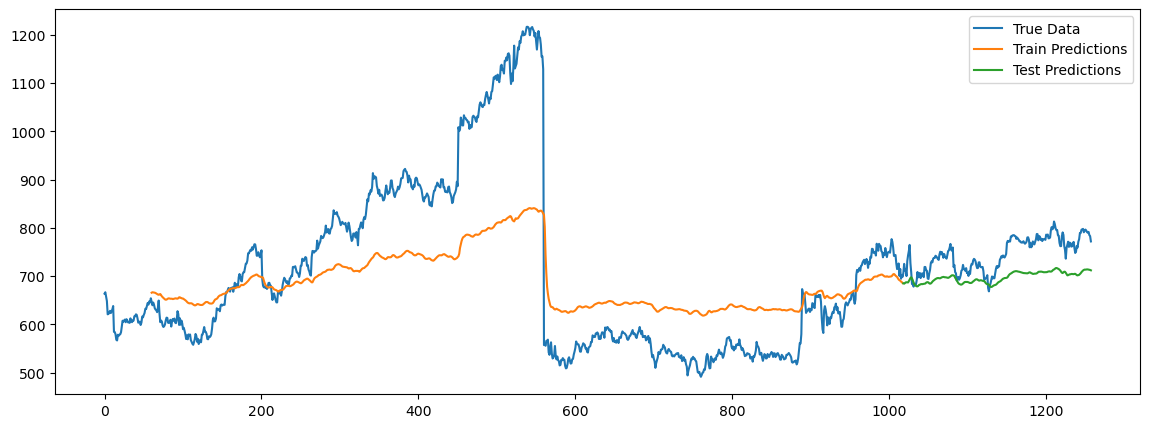

In [27]:
# 결과 시각화
plt.figure(figsize=(14, 5))

# 전체 데이터 시각화
plt.plot(range(len(data)), data, label='True Data')

# 학습 데이터에 대한 예측 시각화
plt.plot(range(time_steps, len(train_predictions) + time_steps), train_predictions, label='Train Predictions')

# 테스트 데이터에 대한 예측 시각화
test_start = len(train_predictions) + time_steps
plt.plot(range(test_start, test_start + len(test_predictions)), test_predictions, label='Test Predictions')

plt.legend()
plt.show()